In [1]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.3 MB/s eta 0:00:00


In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,
                            confusion_matrix,
                            roc_auc_score,
                            accuracy_score)
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')



In [16]:
# Set random seed
np.random.seed(42)
sns.set_style("whitegrid")

In [17]:
# 1. DATA GENERATION
print("Generating synthetic data with realistic distributions...")
fake = Faker()

def generate_customer_data(n=10000):
    data = {
        "customer_id": [fake.uuid4() for _ in range(n)],
        "age": np.clip(np.random.normal(35, 10, n), 18, 70).astype(int),
        "gender": np.random.choice(["M", "F", "Other"], n, p=[0.45, 0.45, 0.1]),
        "income_usd": np.clip(np.random.normal(50000, 15000, n), 10000, 150000).astype(int),
        "total_sessions": np.random.poisson(15, n),
        "avg_session_duration_min": np.clip(np.random.exponential(10, n), 1, 60),
        "products_viewed": np.random.poisson(25, n),
        "cart_additions": np.random.poisson(5, n),
        "total_spent_usd": np.clip(np.random.gamma(100, 2, n), 10, 10000),
        "last_purchase_days_ago": np.clip(np.random.exponential(30, n), 1, 365).astype(int),
        "customer_service_contacts": np.random.poisson(2, n)
    }
    df = pd.DataFrame(data)

    # To make the data realistic, purchases must be <= cart_additions.
    # We model purchases as a binomial draw from cart_additions.
    # Let's assume a 60% probability of a cart item being purchased.
    df["purchases"] = np.random.binomial(n=df["cart_additions"], p=0.6)

    # Derived features
    df["cart_abandonment_rate"] = np.where(
        df["cart_additions"] > 0,
        (df["cart_additions"] - df["purchases"]) / df["cart_additions"],
        0)
    df["purchase_frequency"] = df["purchases"] / (df["total_sessions"] + 1)
    df["conversion_rate"] = df["purchases"] / (df["products_viewed"] + 1)
    df["avg_order_value"] = np.where(
        df["purchases"] > 0,
        df["total_spent_usd"] / df["purchases"],
        0)
    df["churn_risk"] = np.where(df["last_purchase_days_ago"] > 60, 1, 0)

    # Introduce missing values (5% random) in key columns
    cols_with_nulls = ["income_usd", "cart_abandonment_rate", "avg_session_duration_min"]
    for col in cols_with_nulls:
        df.loc[df.sample(frac=0.05).index, col] = np.nan

    return df


Generating synthetic data with realistic distributions...


In [18]:
df = generate_customer_data(10000)
print(f"Data generated: {df.shape[0]} customers, {df.shape[1]} features")

Data generated: 10000 customers, 17 features


In [19]:
# DATA VALIDATION & CLEANING
print("\nPerforming data validation...")

# Check for invalid values
def validate_data(df):
    assert (df["age"] >= 18).all(), "Age < 18 detected"
    assert (df["total_spent_usd"] >= 0).all(), "Negative spending"
    assert df["cart_abandonment_rate"].dropna().between(0, 1, inclusive='both').all(), "Invalid abandonment rate"
    print("✓ Data validation passed")

validate_data(df)


Performing data validation...
✓ Data validation passed


In [20]:
# Handle missing values
print("\nMissing values before handling:")
print(df.isnull().sum())

imputer = SimpleImputer(strategy='median')
num_cols = ["income_usd", "avg_session_duration_min"]
df[num_cols] = imputer.fit_transform(df[num_cols])

# For rates, fill with 0 (assuming no activity)
df["cart_abandonment_rate"].fillna(0, inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())

# Remove duplicates
df.drop_duplicates(subset="customer_id", inplace=True)
print(f"\nFinal dataset size: {len(df)} records")


Missing values before handling:
customer_id                    0
age                            0
gender                         0
income_usd                   500
total_sessions                 0
avg_session_duration_min     500
products_viewed                0
cart_additions                 0
total_spent_usd                0
last_purchase_days_ago         0
customer_service_contacts      0
purchases                      0
cart_abandonment_rate        500
purchase_frequency             0
conversion_rate                0
avg_order_value                0
churn_risk                     0
dtype: int64

Missing values after handling:
customer_id                  0
age                          0
gender                       0
income_usd                   0
total_sessions               0
avg_session_duration_min     0
products_viewed              0
cart_additions               0
total_spent_usd              0
last_purchase_days_ago       0
customer_service_contacts    0
purchases           


Performing EDA...

--- Descriptive Statistics ---
                             count          mean           std           min  \
age                        10000.0     34.683600      9.588988     18.000000   
income_usd                 10000.0  49994.471600  14450.413628  10000.000000   
total_sessions             10000.0     14.988900      3.863505      2.000000   
avg_session_duration_min   10000.0      9.889238      9.466318      1.000000   
products_viewed            10000.0     24.952600      4.990175      8.000000   
cart_additions             10000.0      5.004700      2.231317      0.000000   
total_spent_usd            10000.0    199.984161     20.115021    135.212141   
last_purchase_days_ago     10000.0     29.910400     30.553054      1.000000   
customer_service_contacts  10000.0      1.992900      1.410620      0.000000   
purchases                  10000.0      2.987800      1.738089      0.000000   
cart_abandonment_rate      10000.0      0.381002      0.260527      0

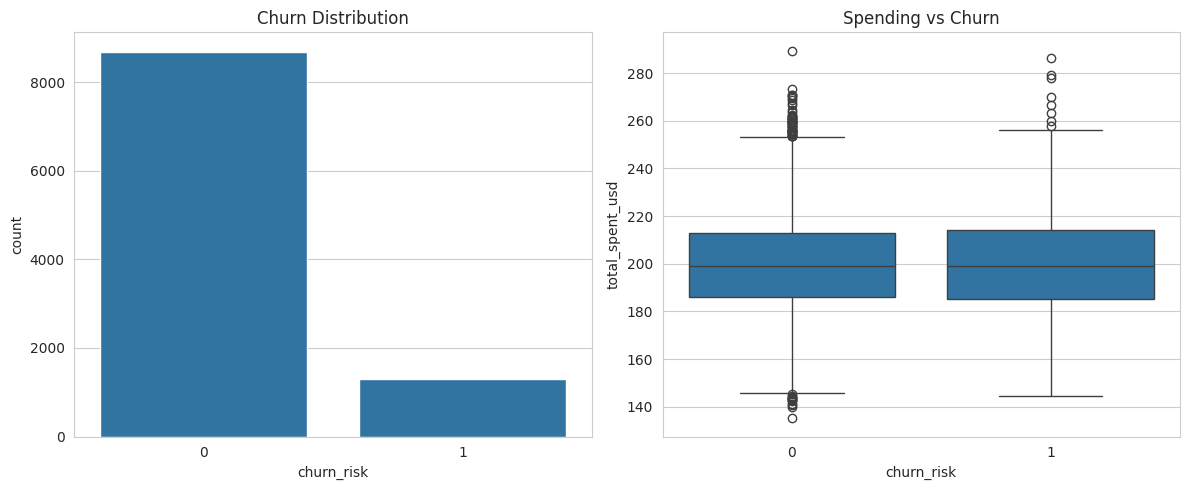

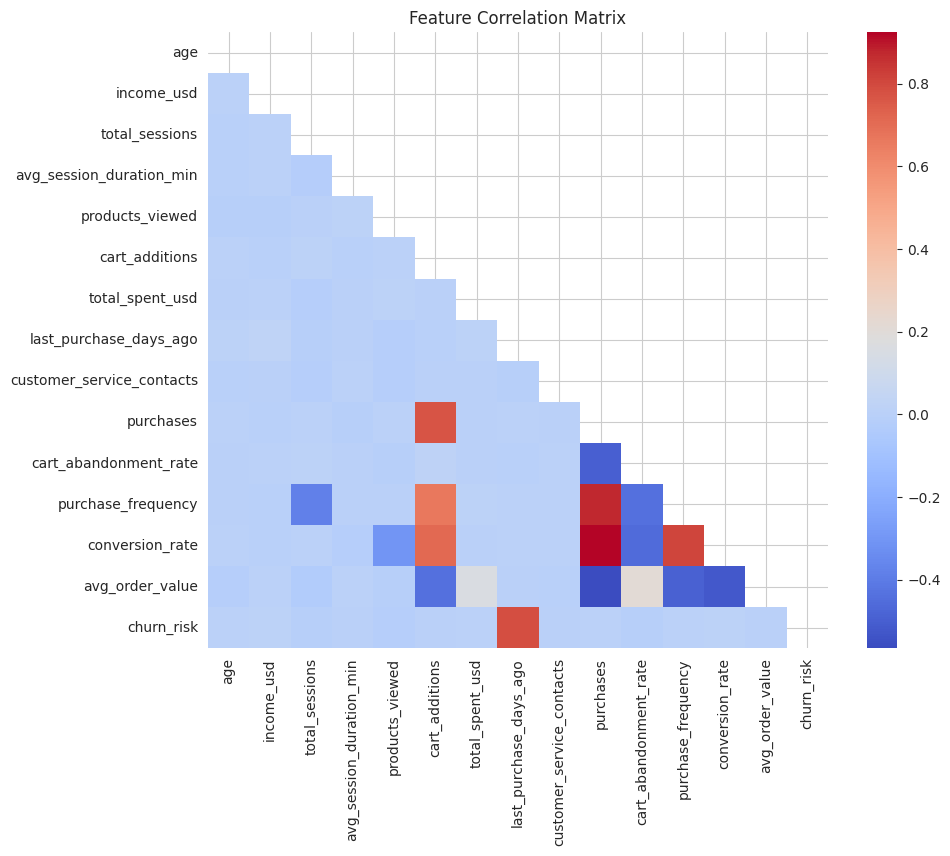

In [21]:
# EXPLORATORY DATA ANALYSIS (EDA)
print("\nPerforming EDA...")

#  Basic Statistics
print("\n--- Descriptive Statistics ---")
print(df.describe().T)

# Target Variable Analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x="churn_risk", data=df)
plt.title("Churn Distribution")

plt.subplot(1, 2, 2)
sns.boxplot(x="churn_risk", y="total_spent_usd", data=df)
plt.title("Spending vs Churn")
plt.tight_layout()
plt.show()

# Correlation Analysis
plt.figure(figsize=(10, 8))
corr_matrix = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr_matrix,
            annot=False,
            cmap="coolwarm",
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title("Feature Correlation Matrix")
plt.show()


In [22]:
# FEATURE ENGINEERING
print("\nFeature engineering...")

# Binning Continuous Variables
df["age_group"] = pd.cut(df["age"],
                         bins=[18, 25, 35, 50, 70],
                         labels=["18-25", "26-35", "36-50", "51+"])

df["spending_tier"] = pd.qcut(df["total_spent_usd"],
                              q=4,
                              labels=["Bronze", "Silver", "Gold", "Platinum"])

# Behavioral Features
df["engagement_score"] = (
    0.3 * MinMaxScaler().fit_transform(df[["total_sessions"]]) +
    0.4 * MinMaxScaler().fit_transform(df[["products_viewed"]]) +
    0.3 * MinMaxScaler().fit_transform(df[["avg_session_duration_min"]])
)

# Normalization
scaler = StandardScaler()
numeric_features = ["age", "income_usd", "avg_session_duration_min", "products_viewed"]
df[numeric_features] = scaler.fit_transform(df[numeric_features])



Feature engineering...



Building churn prediction model...

--- Model Performance ---
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2607
           1       0.00      0.00      0.00       393

    accuracy                           0.87      3000
   macro avg       0.43      0.50      0.46      3000
weighted avg       0.76      0.87      0.81      3000


AUC-ROC: 0.48
Accuracy: 0.87


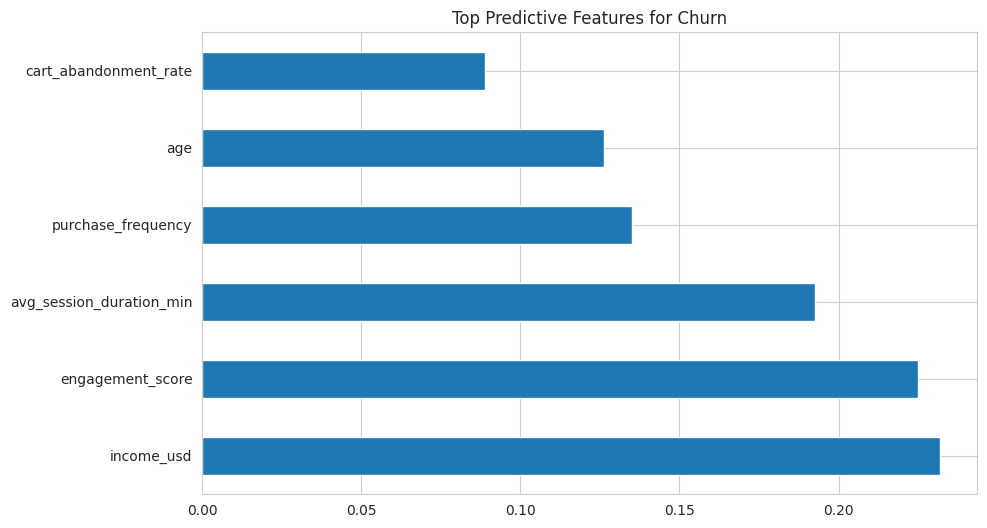

In [23]:
# 5. PREDICTIVE MODELING
# ======================
print("\nBuilding churn prediction model...")

# 5.1 Prepare Data
X = df[[
    "age",
    "income_usd",
    "avg_session_duration_min",
    "purchase_frequency",
    "cart_abandonment_rate",
    "engagement_score"
]]
y = df["churn_risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

#  Train Model
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n--- Model Performance ---")
print(classification_report(y_test, y_pred))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Feature Importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top Predictive Features for Churn")
plt.show()

In [24]:
!pip install -U imbalanced-learn

In [25]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to our training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a new model on the resampled data
model_resampled = RandomForestClassifier(
    n_estimators=150,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42
)
model_resampled.fit(X_train_resampled, y_train_resampled)

# Evaluate the new model on the original test data
y_pred_resampled = model_resampled.predict(X_test)
y_proba_resampled = model_resampled.predict_proba(X_test)[:, 1]

print("\n--- Model Performance (after SMOTE) ---")
print(classification_report(y_test, y_pred_resampled))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba_resampled):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_resampled):.2f}")


--- Model Performance (after SMOTE) ---
              precision    recall  f1-score   support

           0       0.86      0.60      0.71      2607
           1       0.12      0.38      0.19       393

    accuracy                           0.57      3000
   macro avg       0.49      0.49      0.45      3000
weighted avg       0.77      0.57      0.64      3000


AUC-ROC: 0.48
Accuracy: 0.57


In [26]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation on the original test set
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

print("\n--- Gradient Boosting Model Performance (after SMOTE) ---")
print(classification_report(y_test, y_pred_gb))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba_gb):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.2f}")


--- Gradient Boosting Model Performance (after SMOTE) ---
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2607
           1       0.11      0.07      0.09       393

    accuracy                           0.80      3000
   macro avg       0.49      0.49      0.49      3000
weighted avg       0.77      0.80      0.78      3000


AUC-ROC: 0.49
Accuracy: 0.80


In [27]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6]
}

# Initialize the Grid Search with our model and parameter grid
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    scoring='roc_auc',  # Focus on improving the AUC-ROC score
    verbose=2
)

# Fit the Grid Search to our resampled data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the best model
print("\nBest parameters found:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_rf_model.predict(X_test)
y_proba_tuned = best_rf_model.predict_proba(X_test)[:, 1]

print("\n--- Tuned Random Forest Model Performance ---")
print(classification_report(y_test, y_pred_tuned))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba_tuned):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.2f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best parameters found: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

--- Tuned Random Forest Model Performance ---
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      2607
           1       0.13      0.26      0.17       393

    accuracy                           0.67      3000
   macro avg       0.50      0.50      0.49      3000
weighted avg       0.77      0.67      0.72      3000


AUC-ROC: 0.49
Accuracy: 0.67


In [28]:
# Advanced Feature Engineering
print("\nCreating advanced features...")

# Interaction Features
df['income_per_session'] = df['income_usd'] / (df['total_sessions'] + 1)
df['spending_per_session'] = df['total_spent_usd'] / (df['total_sessions'] + 1)

# Time-Based Features
def get_recency_category(days):
    if days <= 30:
        return 'Recent'
    elif days <= 90:
        return 'Lapsed'
    else:
        return 'Dormant'

df['recency_category'] = df['last_purchase_days_ago'].apply(get_recency_category)

# Behavioral Ratios
df['cart_to_view_ratio'] = df['cart_additions'] / (df['products_viewed'] + 1)
df['purchase_to_contact_ratio'] = df['purchases'] / (df['customer_service_contacts'] + 1)


# One-hot encode the new categorical feature
df = pd.get_dummies(df, columns=['recency_category'], drop_first=True)


# Prepare the new feature set
X_advanced = df[[
    "age",
    "income_usd",
    "avg_session_duration_min",
    "purchase_frequency",
    "cart_abandonment_rate",
    "engagement_score",
    "income_per_session",
    "spending_per_session",
    "cart_to_view_ratio",
    "purchase_to_contact_ratio",
    "recency_category_Lapsed",
    "recency_category_Recent"
]]
y_advanced = df["churn_risk"]

X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_advanced, y_advanced, test_size=0.3, random_state=42, stratify=y_advanced)


# Apply SMOTE to the new training data
smote_adv = SMOTE(random_state=42)
X_train_resampled_adv, y_train_resampled_adv = smote_adv.fit_resample(X_train_adv, y_train_adv)


# Retrain the best model on the new feature set
best_rf_model.fit(X_train_resampled_adv, y_train_resampled_adv)

# Evaluate the model with advanced features
y_pred_adv = best_rf_model.predict(X_test_adv)
y_proba_adv = best_rf_model.predict_proba(X_test_adv)[:, 1]

print("\n--- Model Performance with Advanced Features ---")
print(classification_report(y_test_adv, y_pred_adv))
print(f"\nAUC-ROC: {roc_auc_score(y_test_adv, y_proba_adv):.2f}")
print(f"Accuracy: {accuracy_score(y_test_adv, y_pred_adv):.2f}")


Creating advanced features...

--- Model Performance with Advanced Features ---
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      2607
           1       0.38      0.81      0.52       393

    accuracy                           0.80      3000
   macro avg       0.67      0.81      0.70      3000
weighted avg       0.89      0.80      0.83      3000


AUC-ROC: 0.92
Accuracy: 0.80



--- Feature Importance Analysis ---


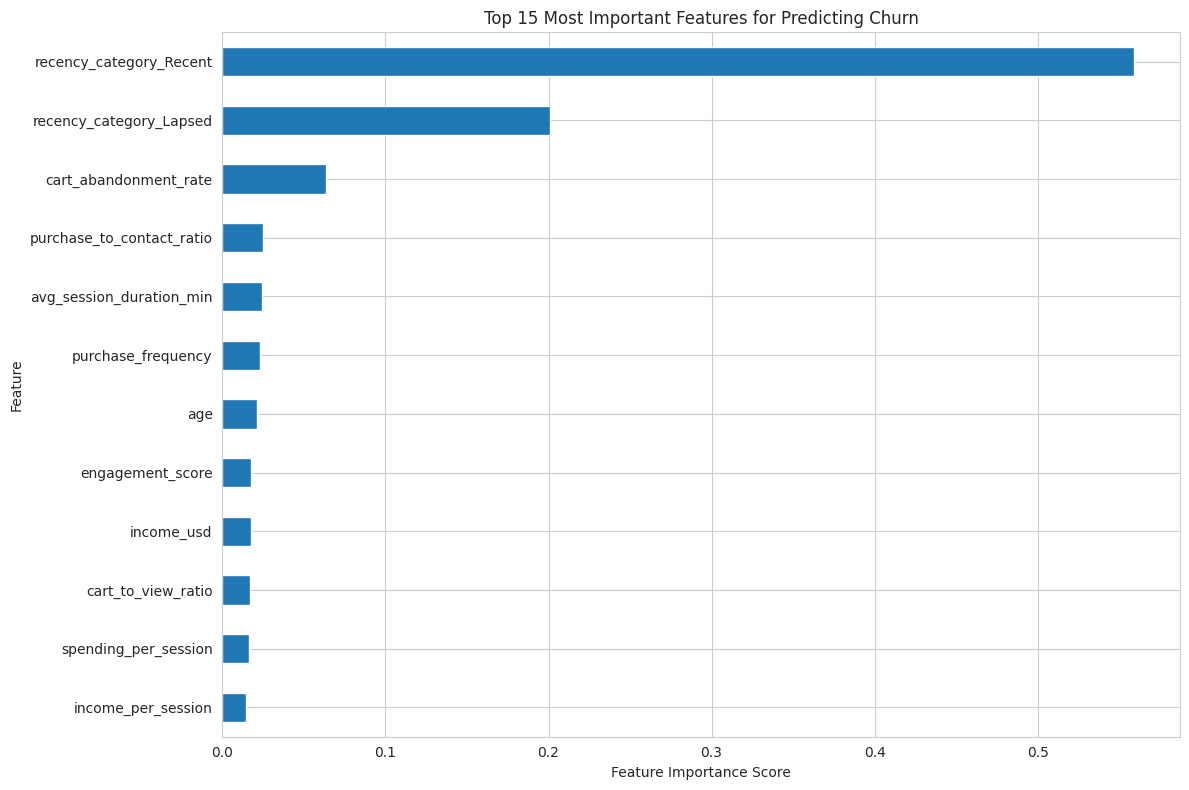

In [29]:
# Analyze Feature Importance
print("\n--- Feature Importance Analysis ---")

# Create a series for feature importances
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_advanced.columns)

# Plot the most important features
plt.figure(figsize=(12, 8))
feature_importances.nlargest(15).sort_values().plot(kind='barh')
plt.title("Top 15 Most Important Features for Predicting Churn")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [30]:
# Save the DataFrame to a CSV file
df.to_csv("customer_churn_dataset.csv", index=False)

print("Dataset saved to customer_churn_dataset.csv")

Dataset saved to customer_churn_dataset.csv
